In [1]:
"""
Importing dependenceis
    - Outside packages
    - Custom classes
"""

# Outside packages
import os
import sys
import numpy as np
import torch
from torch import optim
import albumentations as A
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import itertools
from tensorboardX import SummaryWriter
import cv2

# Custom classes
sys.path.append('./modules')
from datatools import *
from losstools import loss_function_wrapper
from models import Hourglass

In [2]:
"""
Declaring tunable hyperparameters
"""

# dataset generation hyperparameters
patch_size = 200
sigma = 9

# training hyperparameters
epochs = 0.5e3
lr = 5e-4
batch_size = 25
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Hourglass(depth=2)
model.load_state_dict(torch.load('../../Downloads/old_1/depth=2, gce, epoch=00500.pth', 
                                 map_location=torch.device('cpu')))
model = model.to(device)
loss_func = loss_function_wrapper('gcel')
transform = A.Compose([
    A.RandomRotate90(p=1),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [3]:
# """
# Constructing a pipeline to control how data is used by the model
#     - Temporary dataset creation: split dataset's patches into training and validation groups
#         * use 20190822...11.48.51 AM patch_[range(5, 76, 5)].jpg for training
#         * use 20190822...11.48.51 AM patch_[80].jpg for validation
#     - Dataloader creation: package lists of patches into torch Dataloaders
# """

# # Temporary dataset creation
# parent_dir = make_dataset('./dataset',
#                           sigma=sigma,
#                           patch_size=patch_size)
# exclude_list = ['20190822_movie_01_SampleOldA1_120kV_81x2048x2048_30sec_Aligned 11.48.51 AM patch_080.jpg']
# train_ds, val_ds = load_temp_dataset(parent_dir, exclude_list)

# # Dataloader creation
# train_ds = MapDataset(train_ds)
# val_ds = MapDataset(val_ds)
# train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=1)
# val_loader = torch.utils.data.DataLoader(val_ds, shuffle=False, batch_size=1)

In [4]:
# # view performance on patches (1/2)

# """
# val_view_generator: lil generator function to view model's predictions on validation data. left is
#     source image, middle is the target, right is the model's prediction
# """
# def val_view_generator(val_loader):
#     with torch.no_grad():
#         model.eval()
#         for x, y in val_loader:
#             x, y = x.to(device), y.to(device)
#             pred = model(x)

#             plt.figure(figsize=[15, 5])
#             for index, target in enumerate([x, y, pred]):
#                 plt.subplot(1, 3, index+1)
#                 plt.axis('off')
#                 target = target.detach().cpu().numpy().squeeze()
#                 if index == 0:
#                     plt.imshow(target, cmap='Greys_r')
#                 else:
#                     plt.imshow(target, cmap='jet')

#             yield 1

# val_gen = val_view_generator(val_loader)

In [5]:
# # view performance on patches (2/2)

# next(val_gen)

In [6]:
# view performance on entire validation image
parent_dir = './temp_datasets/ds_0'

val_image_name = '20190822_movie_01_SampleOldA1_120kV_81x2048x2048_30sec_Aligned 11.48.51 AM patch_080.jpg'
val_image_path = os.path.join(parent_dir, 'images', val_image_name)
val_mask_path = os.path.join(parent_dir, 'masks', val_image_name)

val_image = np.expand_dims(np.array(Image.open(val_image_path).convert('L')), [0, 1])
val_mask = np.expand_dims(np.array(Image.open(val_mask_path).convert('L')).T, [0, 1])
pred_mask = np.zeros(val_mask.squeeze().shape)

def write_to_pred(y, x):
    with torch.no_grad():
        model.eval()
        image_patch = val_image[y:y+patch_size, x:x+patch_size]
        pred_patch = model(torch.Tensor(image_patch).to(device))
        pred_patch = pred_patch.detach().cpu().numpy().squeeze()
        pred_mask[y:y+patch_size, x:x+patch_size] = np.maximum(pred_mask[y:y+patch_size, x:x+patch_size],
                                                              pred_patch)


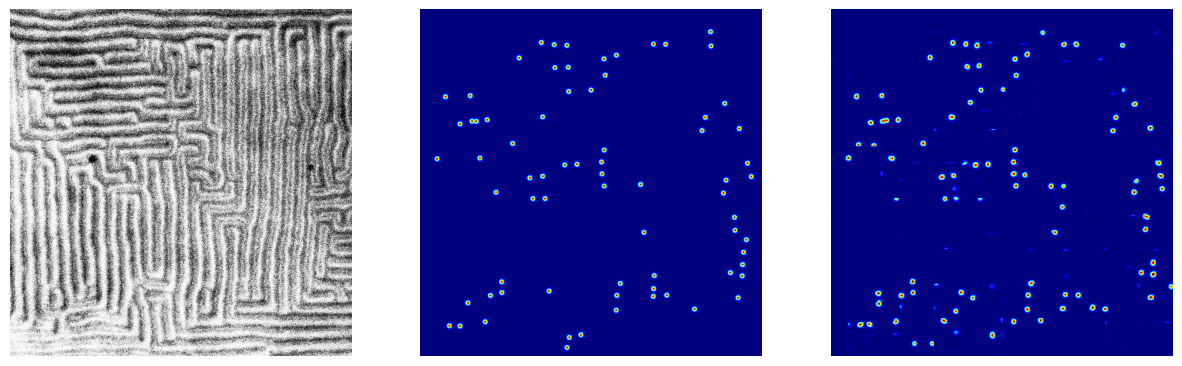

In [7]:
# view performance on entire validation image

val_image_name = '20190822_movie_01_SampleOldA1_120kV_81x2048x2048_30sec_Aligned 11.48.51 AM patch_080.jpg'
val_image_path = os.path.join(parent_dir, 'images', val_image_name)
val_mask_path = os.path.join(parent_dir, 'masks', val_image_name)

val_image = np.array(Image.open(val_image_path).convert('L')).astype(np.float32) / 255
val_mask = np.array(Image.open(val_mask_path).convert('L')).astype(np.float32) / 255
pred_mask = np.zeros(val_mask.shape)

def write_to_pred(y, x):
    with torch.no_grad():
        model.eval()
        image_patch = np.expand_dims(val_image[y:y+patch_size, x:x+patch_size], [0, 1])
        pred_patch = model(torch.Tensor(image_patch).to(device))
        pred_patch = pred_patch.detach().cpu().numpy().squeeze()
        pred_mask[y:y+patch_size, x:x+patch_size] = np.maximum(pred_mask[y:y+patch_size, x:x+patch_size],
                                                              pred_patch)

for y, x in itertools.product(range(0, val_image.shape[0] - patch_size, 100),
                             range(0, val_image.shape[1] - patch_size, 100)):
    write_to_pred(y, x)

y = val_image.shape[0] - patch_size
for x in range(0, val_image.shape[1] - patch_size, 100):
    write_to_pred(y, x)

x = val_image.shape[0] - patch_size
for y in range(0, val_image.shape[0] - patch_size, 100):
    write_to_pred(y, x)

y, x = (val_image.shape[0] - patch_size, val_image.shape[1] - patch_size)
write_to_pred(y, x)

plt.figure(figsize=[15, 5])
for index, target in enumerate([val_image, val_mask, pred_mask]):
    plt.subplot(1, 3, index+1)
    plt.axis('off')
    if index == 0:
        plt.imshow(target, cmap='Greys_r')
    else:
        plt.imshow(target, cmap='jet')

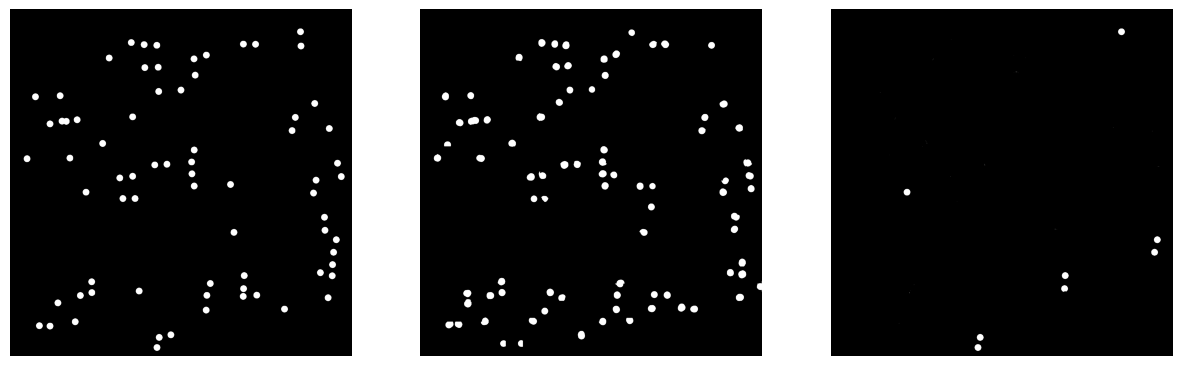

In [8]:
# view performance on entire validation image (2/3)

thresh = 0.1
val_mask = val_mask >= thresh
pred_mask = pred_mask >= thresh

thresh = 900
plt.figure(figsize=[15, 5])
pred_mask_stats = cv2.connectedComponentsWithStats(pred_mask.astype(np.uint8))[2][1:]
for x, y, width, height, area in pred_mask_stats:
    if area < thresh:
        pred_mask[y:y+height, x:x+width] = 0

mask_diff = (val_mask == 1) * (pred_mask == 0)
mask_diff_stats = cv2.connectedComponentsWithStats(mask_diff.astype(np.uint8))[2][1:]
for x, y, width, height, area in mask_diff_stats:
    if area <= (0.7 * width * height):
        mask_diff[y:y+height, x:x+width] = 0

for index, target in enumerate([val_mask, pred_mask, mask_diff]):
    plt.subplot(1, 3, index+1)
    plt.axis('off')
    plt.imshow(target, cmap="Greys_r")

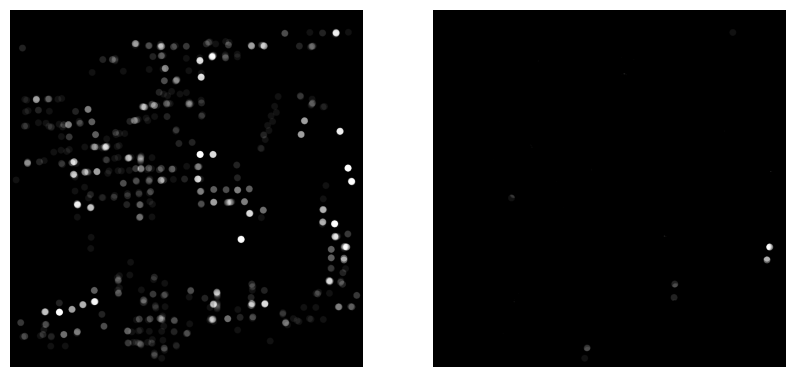

In [9]:
# view performance on entire validation image (3/3)

slate = np.zeros(val_image.shape)
thresh = 0.1

val_image_path

for name in map(lambda x: '20190822_movie_01_SampleOldA1_120kV_81x2048x2048_30sec_Aligned 11.48.51 AM patch_{:03}.jpg'.format(x), range(0, 81, 5)):
    temp = np.array(Image.open(os.path.join(parent_dir, 'masks', name)).convert('L')) / 255
    temp = temp >= thresh
    slate += temp

plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(slate, cmap='Greys_r')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(slate * mask_diff, cmap='Greys_r')